In [ ]:
#Install the libraries
!pip install pandas
!pip install openai
!pip install numpy
!pip install seaborn 
!pip install matplotlib
!pip install Jinja2

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import re

# Load datasets
d = pd.read_csv("redditdata.csv")
d2 = pd.read_csv("otherredditdata.csv")

# Frequency tables
print("Political Lean distribution:")
print(d['Political Lean'].value_counts(dropna=False))
print("\nSubreddit distribution:")
print(d['Subreddit'].value_counts(dropna=False))

# Combine 'Title' and 'Text' into a single 'post' column
d['post'] = d['Title'].astype(str) + " - " + d['Text'].astype(str)

# Replace empty strings with NaN
d.replace("", np.nan, inplace=True)

# Count missing values
print("\nMissing values in d:")
print(d.isna().sum())

text_rows = d['Text'].notna().sum()
print(f"Rows with non-missing text: {text_rows}")
print(f"Total rows: {len(d)}")
print(f"Missing text rows: {len(d) - text_rows}")

# d2 frequency table
print("\nd2 subreddit distribution:")
print(d2['subreddit'].value_counts(dropna=False))

# Replace empty strings with NaN in d2
d2.replace("", np.nan, inplace=True)

# Missing values in d2
print("\nMissing values in d2:")
print(d2.isna().sum())

text_rows_d2 = d2['selftext'].notna().sum()
print(f"Rows with non-missing selftext: {text_rows_d2}")
print(f"Missing selftext rows: {len(d2) - text_rows_d2}")

# Filter d2 for rows with selftext
d2_onlytext = d2[d2['selftext'].notna()]
print("\nMissing values in d2_onlytext:")
print(d2_onlytext.isna().sum())

print("\nd2_onlytext subreddit distribution:")
print(d2_onlytext['subreddit'].value_counts(dropna=False))

# Inspect row 7619
print("\nRow 7619 of d2:")
print(d2.loc[7618])

# Merge datasets
d_subset = d[['Title', 'Text', 'Subreddit']].rename(columns={
    'Title': 'title',
    'Text': 'text',
    'Subreddit': 'subreddit'
})

d2_subset = d2[['title', 'selftext', 'subreddit']].rename(columns={
    'selftext': 'text'
})

df = pd.concat([d_subset, d2_subset], ignore_index=True)

# --- Clean text: remove URLs and whitespace ---
def clean_text(text):
    url_pattern = r'http[s]?://\S+|www\.\S+'
    text = re.sub(url_pattern, '', str(text))
    return text.strip()

df['text'] = df['text'].apply(clean_text)

# Preview cleaned merged DataFrame
print("\nPreview of cleaned merged dataframe:")
print(f"\nMerged dataset shape: {df.shape}")
print(df.head())

# Save to file
df.to_pickle("merged_reddit_data.pkl")
df.to_csv("merged_reddit_data.csv", index=False)

Political Lean distribution:
Political Lean
Liberal         8319
Conservative    4535
Name: count, dtype: int64

Subreddit distribution:
Subreddit
conservatives          1000
alltheleft              997
SocialDemocracy         997
Libertarian             975
Capitalism              975
socialism               975
progressive             974
republicans             948
democrats               941
feminisms               935
DemocraticSocialism     922
Liberal                 904
anarchocapitalism       637
Communist               574
RadicalFeminism         100
Name: count, dtype: int64

Missing values in d:
Title                  0
Political Lean         0
Score                  0
Id                     0
Subreddit              0
URL                    0
Num of Comments        0
Text               10426
Date Created           0
post                   0
dtype: int64
Rows with non-missing text: 2428
Total rows: 12854
Missing text rows: 10426

d2 subreddit distribution:
subreddit
neoliber

In [ ]:
import time
from openai import OpenAI, OpenAIError

# Initialize OpenAI client
client = OpenAI(api_key="sk-proj...")

# Constants
MODEL = "gpt-4.1-mini"
INPUT_FILE = "merged_reddit_data.pkl"
OUTPUT_FILE = "outgroup_analysis_sample2000.pkl"
SAMPLE_SIZE = 2000
WAIT_TIME = 0.8

# Load and preprocess data
df = pd.read_pickle(INPUT_FILE)
df = df[['title', 'text', 'subreddit']].copy()
df = df.dropna(subset=['title', 'text'])
df = df[(df['title'].str.strip() != "") & (df['text'].str.strip() != "")]

# Sample 500 posts randomly
df_sample = df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)
df_sample['outgroup'] = None

# Revised outgroup prompt
OUTGROUP_PROMPT = (
    "You are a political scientist with expertise in affective polarization and outgroup dynamics. "
    "Your task is to identify the outgroup targeted in a political social media post (if any). In the context of research "
    "on affective polarization, the outgroup is a group with a different political or social identity than the person writing the post "
    "and is often met with negative feelings.\n\n"
    "Use only the content of the post for analysis. You may use the subreddit name for general context only when necessary "
    "to disambiguate vague references (e.g., 'they,' 'those people'). Do not use the subreddit as part of the post content.\n\n"
    "Inductively identify the outgroup based on the content. Use your judgment to determine the most accurate and specific label for the group being targeted or criticized. "
    "Keep the label as short as possible without important information (maximum 10 words).\n\n"
    "If the post targets an abstract or vaguely defined group, infer the most plausible outgroup based on context. If necessary, assign a general label "
    "(e.g., 'Ideological opponents' or 'Political elites'). Do not over-interpret.\n\n"
    "Prefer existing labels when possible.\n\n"
    "Respond only with the name of the outgroup. If no outgroup is present, respond with: No outgroup."
)

# Analysis function
def analyze_outgroup(title, text, subreddit, model=MODEL, temperature=0.2):
    tries = 0
    combined_post = f"Title: {title.strip()}\nText: {text.strip()}"
    context_note = f"(Subreddit context: {subreddit})"

    user_input = f"{combined_post}\n\n{context_note}"

    while tries < 5:
        try:
            response = client.chat.completions.create(
                model=model,
                temperature=temperature,
                messages=[
                    {"role": "system", "content": OUTGROUP_PROMPT},
                    {"role": "user", "content": user_input}
                ]
            )
            return response.choices[0].message.content.strip("'\"")
        except Exception as e:
            print(f"Error (try {tries + 1}): {e}")
            tries += 1
            time.sleep(2)
    return "Error"

# Main loop
for i, row in df_sample.iterrows():
    print(f"Analyzing post {i + 1}/{SAMPLE_SIZE}...")
    outgroup = analyze_outgroup(row['title'], row['text'], row['subreddit'])
    df_sample.at[i, 'outgroup'] = outgroup
    time.sleep(WAIT_TIME)

# Save results
df_sample.to_pickle(OUTPUT_FILE)
print(f"Saved labeled sample to {OUTPUT_FILE}")


Analyzing post 1/2000...
Analyzing post 2/2000...
Analyzing post 3/2000...
Analyzing post 4/2000...
Analyzing post 5/2000...
Analyzing post 6/2000...
Analyzing post 7/2000...
Analyzing post 8/2000...
Analyzing post 9/2000...
Analyzing post 10/2000...
Analyzing post 11/2000...
Analyzing post 12/2000...
Analyzing post 13/2000...
Analyzing post 14/2000...
Analyzing post 15/2000...
Analyzing post 16/2000...
Analyzing post 17/2000...
Analyzing post 18/2000...
Analyzing post 19/2000...
Analyzing post 20/2000...
Analyzing post 21/2000...
Analyzing post 22/2000...
Analyzing post 23/2000...
Analyzing post 24/2000...
Analyzing post 25/2000...
Analyzing post 26/2000...
Analyzing post 27/2000...
Analyzing post 28/2000...
Analyzing post 29/2000...
Analyzing post 30/2000...
Analyzing post 31/2000...
Analyzing post 32/2000...
Analyzing post 33/2000...
Analyzing post 34/2000...
Analyzing post 35/2000...
Analyzing post 36/2000...
Analyzing post 37/2000...
Analyzing post 38/2000...
Analyzing post 39/200

In [11]:
df = pd.read_pickle("outgroup_analysis_sample2000.pkl")
df.to_csv("outgroup_analysis_sample2000.csv", index=False)

In [ ]:
# Show all rows in value_counts output
pd.set_option('display.max_rows', None)

# Load the CSV file
df = pd.read_csv("outgroup_analysis_sample2000.csv")

# Get all unique outgroup labels
unique_outgroups = df['outgroup'].unique()
print("Unique outgroups:", unique_outgroups)
print("Number of unique outgroups:", len(unique_outgroups))

# Show all frequencies
print(df['outgroup'].value_counts())

Unique outgroups: ['Capitalists' 'No outgroup.' 'US elites' 'Undocumented immigrants'
 'Political elites' 'US police agencies' 'Fascists'
 'Government authorities' 'Anti-Communists' 'Anarchists'
 'Illegal migrants' 'Red States' 'Communists' 'Liberals' "India's elite"
 'China' 'Center/liberal people' 'U.S. government supporters'
 'Republicans' 'Trump Administration' 'Woke corporations' 'Canadians'
 'Those harmed by the vaccine' 'Progressive educators'
 'White supremacists' 'Supporters of the former president' 'Bolsheviki'
 'Trump administration' 'Ultraconservatives' 'Democrats' 'The state'
 'Immigration enforcement agents' 'Loser Left' 'Far-right conservatives'
 'Anti-abortion activists' 'Liberal Reddit users' 'KKK supporters'
 'Mainstream Media' 'Republican Party' 'Trump supporters'
 'Alt-Right individuals' 'American companies' 'Fox News'
 'Utah Republicans' 'Chinese Communist Party' 'Nationalists'
 'Biden Administration' 'Hillary Clinton supporters' 'Biden supporters'
 'Statists' 'Pro

In [ ]:
# Set up the OpenAI client
client = openai.OpenAI(api_key="sk-proj...")

# Your input list
outgroups = [
 'Capitalists' 'No outgroup.' 'US elites' 'Undocumented immigrants'
 'Political elites' 'US police agencies' 'Fascists'
 'Government authorities' 'Anti-Communists' 'Anarchists'
 'Illegal migrants' 'Red States' 'Communists' 'Liberals' "India's elite"
 'China' 'Center/liberal people' 'U.S. government supporters'
 'Republicans' 'Trump Administration' 'Woke corporations' 'Canadians'
 'Those harmed by the vaccine' 'Progressive educators'
 'White supremacists' 'Supporters of the former president' 'Bolsheviki'
 'Trump administration' 'Ultraconservatives' 'Democrats' 'The state'
 'Immigration enforcement agents' 'Loser Left' 'Far-right conservatives'
 'Anti-abortion activists' 'Liberal Reddit users' 'KKK supporters'
 'Mainstream Media' 'Republican Party' 'Trump supporters'
 'Alt-Right individuals' 'American companies' 'Fox News'
 'Utah Republicans' 'Chinese Communist Party' 'Nationalists'
 'Biden Administration' 'Hillary Clinton supporters' 'Biden supporters'
 'Statists' 'Pro-slavery Democrats' 'Moderate conservatives'
 'Kamala Harris supporters' 'Wealthy gentrifiers' 'Wealthy elites'
 'Pharmaceutical and health insurance companies' 'Leftists'
 'Government agents' 'Conservatives' 'Socialists'
 'Alt-right and Conservative ideology' 'Corporations'
 'Coca Cola executives' 'Right-wing individuals' 'Texas Republicans'
 'Landlords' 'The left' 'Hollywood' 'Police officers'
 'Anti-LGBTQ individuals' 'Conservative agitators' 'Scientists'
 'Far-left party members' 'Ultra wealthy 0.1%ers' 'Anti-CRT advocates'
 'Western Leftists' 'Bollywood.' 'Never-Trump Republicans' 'David Hogg'
 'Colombian government' 'CNN viewers'
 'ICE (Immigration and Customs Enforcement)' 'Israeli government'
 'Trump officials' 'Divisive teachers' 'Journalists'
 'Public health officials' 'Wealthy individuals'
 'Corporate media and social media companies' 'Union-busting industry'
 'US government' 'Pro-migration lobbyists' 'Florida Democrats' 'Big oil'
 'Political leaders' 'Tories' 'The you know who' 'Christian Nationalists'
 'Donald Trump and his children' 'Professional-managerial class'
 'Uncommitted delegates' 'DNC Democrats' 'Jeff Bezos supporters'
 'Left-wing activists' 'Nazis' 'Republican party and administration'
 'Trump allies' 'Democratic socialists' 'US-funded separatists'
 "Progressives opposed to 'Latinx' usage" 'Fascists and capitalists'
 'Protesters' 'Supporters of Universal Basic Income (UBI)'
 'Militia allies' 'Men' 'Supporters of Trump' 'Illegal aliens'
 'U.S.-Trained Soldiers' 'Democratic Party' 'MAGA supporters' 'Teachers'
 'Ivy League elites' 'GQP supporters' 'Working people'
 'Right wing colleagues' 'Third way proponents' 'Modern leftists'
 'U.S. officials and European leaders' 'Christian nationalists'
 'Idaho progressives' 'Trump foes' 'The Federal Reserve and its owners'
 'Liberal media' 'Billionaires' 'Transgender activists'
 'Ukrainian Neo-Nazi groups' 'Business groups' 'Donald Trump supporters'
 'ISIS' 'Conservative book banners' "Men's Rights Activists (MRAs)"
 'Libertarians' 'Warmongers' 'Leftist statists' 'Radical feminists'
 'Lefties' 'The Left' 'Economic oppressors' 'US and European politicians'
 'Republican politicians' 'Supporters of Donald Trump' 'Jewish activists'
 'Far-right parties' 'Election conspiracy theorists' 'Employers'
 'The Government' 'Transgender youths' 'Right-wingers' 'QAnon supporters'
 'Fox News viewers' 'Republicans and corporate elites' 'Populist right.'
 'Mega corporations' 'Communists/Marxist-Leninists' 'Police critics'
 'Far-right groups' 'Pro-choice advocates' 'Big Pharma'
 'Men who deny patriarchy' 'Anti-vaccine individuals' 'Trans activists'
 'MAGAs' 'Elite capitalists' 'Marxist-Leninists' 'Federal health workers'
 'Marxists' 'Religious conservatives' 'Anti-Trump Republicans'
 'Political authority' 'Transgender individuals' 'Progressives'
 'Corporate executives' 'Scandinavian prison systems'
 'Conservative Party supporters' 'Climate alarmists' 'The top 1%'
 'Chinese Communist Party (CCP)' 'Immigrants' 'Religious individuals'
 'Student-loan companies' 'Capitalist governments' 'Liberal economists'
 'Social Democrats' 'Deep State' 'Left Wing Capitalists'
 'Anti-vaccine protesters' 'Israeli settlers' 'Hillary Clinton'
 'Mainstream news outlets' 'Conservative men' 'Argentina'
 'Pro-Palestinian activists' 'Pro-sex work advocates'
 'WEF (World Economic Forum)' 'Conservative elected officials'
 'Insurrectionists' 'Transgender minors' 'Republican lawmakers'
 'Antiwork movement' 'The Right' 'Republican Party supporters'
 'Pro-intervention politicians and media figures' 'Federal employees'
 'USAID' 'QAnon followers' "Canada's Conservatives"
 'Food bank corporations' 'Conspiracy theorists'
 'Reactionary politics supporters' 'Red states'
 'Freedom Convoy supporters' 'Mao Zedong romanticists' 'Trans people'
 'Republican Party members' 'Power elite' 'Russian colonialism'
 'Cristina Fernández de Kirchner supporters' 'The Taliban' 'White men'
 'Bankers' 'Democrats/leftists' 'Governments' 'Conservative Christians'
 'Freeloaders' 'Far-right individuals' 'The rich' 'Chinese billionaires'
 'U.S. Immigration and Customs Enforcement (ICE)'
 'Conservative politicians' 'Proponents of capitalism' 'Oath Keepers'
 'Socialists/Communists' 'Wealthy capitalists' 'Far-right extremists'
 'Billionaire capitalists' 'Mitch McConnell supporters' 'Far left.'
 'Corporate party elites' 'Masking advocates' 'Non BIPOC people'
 'Social media groups' 'Mainstream media' 'Fellow GOP members'
 'Ukrainian government officials' 'Dr. Anthony Fauci' 'Kazakh Government'
 'White colleagues' 'Politicians and government workers'
 'Ukrainian government' 'Those in love with money and red hats'
 'Transgender community' 'The right' 'Trump family' 'The press corps'
 'TERFs' 'Russian companies' 'Rural Trump voters' 'Centrists' 'Academics'
 'Imperialist forces' 'Ultra MAGA supporters' 'Poor people'
 'Republican Senators' 'Bureaucrats and politicians' 'Zionists' 'Workers'
 'People who do not identify as gender nonconforming' 'Incels' 'Commies'
 'Chinese government and its allies' 'U.S. government officials'
 'Florida GOP' 'Traitors' 'Native Americans' 'Police' 'NATO/US'
 'The white class' 'Anti-LGBT+ lawmakers' 'US Big Tech' 'DEI advocates'
 'Government officials' 'Israel' 'The Far Right' 'Israeli supporters'
 'White people' 'The average individual' 'Wealthy families'
 'Conservative opponents' 'Fox News hosts' 'Modern capitalists'
 'NATO supporters' 'Israeli settlements' 'Liberal insiders'
 'American Republicans and Arab Muslims' 'Doomers' 'Transgender opponents'
 'Ideological opponents' 'DSA supporters' 'Pro-war advocates'
]

# Format the list as a string
outgroup_string = '\n'.join([f"- {item}" for item in outgroups])

# Construct the prompt
prompt = f"""
You are a political scientist with expertise in affective polarization, elite theory, partisanship, nationalism, and culture war conflicts.

Please condense the following list of political or social outgroups into **20 generalizable and theoretically coherent categories**, based on established literature in political science.

Make sure to separate ordinary citizens from elites/higher-level entities. For instance, do not put Trump supporters and Trump administration into the same category. 
Also, make sure to distinguish between partisans (like Republican or Democrat voters/supporters) and people with more abstract ideologies (like conservatives or liberals/leftists).
Moreover, distinguish between Republicans/Trump supporters and far-right conservatives/alt-right supporters/KKK supporters. 

Each category should:
- Group related outgroups under a unifying theoretical label,
- Be distinct and mutually exclusive,
- Include a short label (2-10 words),
- Be useful for empirical coding of political discourse.

Provide the output as a list of 20 categories. For each, give:
1. A short category label,
2. 2-5 example outgroups from the original list that fall into that category.

Here is the list:

{outgroup_string}
"""

# Send to GPT-4.1 (or GPT-4)
response = client.chat.completions.create(
    model="gpt-4",  # You can use "gpt-4", "gpt-4-turbo", or "gpt-4o"
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt}
    ],
    temperature=0.3
)

# Print the result
print(response.choices[0].message.content)


1. **Category: Nationalist Entities**
   - Examples: Nationalists, Christian Nationalists, Israeli settlers

2. **Category: Political Elites**
   - Examples: U.S. government officials, Political leaders, Trump Administration

3. **Category: Political Party Supporters**
   - Examples: Supporters of the former president, Biden supporters, Hillary Clinton supporters

4. **Category: Media Entities**
   - Examples: Mainstream Media, Fox News, Corporate media and social media companies

5. **Category: Ideological Extremists**
   - Examples: Fascists, Nazis, Far-right conservatives

6. **Category: Economic Elites**
   - Examples: Capitalists, Wealthy elites, Billionaire capitalists

7. **Category: Institutional Authorities**
   - Examples: US police agencies, Immigration enforcement agents, U.S. Immigration and Customs Enforcement (ICE)

8. **Category: Corporate Entities**
   - Examples: American companies, Pharmaceutical and health insurance companies, Mega corporations

9. **Category: Ideol

In [ ]:
import re
from openai import OpenAI, BadRequestError

# === CONFIGURATION ===
client = OpenAI(api_key="sk-proj...")
MODEL = "gpt-4.1-mini"
INPUT_FILE = "merged_reddit_data.pkl"
OUTPUT_PICKLE = "reddit_data_llm_analysis_finalver.pkl"
OUTPUT_CSV = "reddit_data_llm_analysis_finalver.csv"
BATCH_SIZE = 5
WAIT_TIME = 2
# SAMPLE_SIZE = 500 
# For initial testing, a sample of 500 posts were used before conducting the full analysis to make sure the code worked as expected.

# === PROMPTS ===
OUTGROUP_PROMPT_BASE = """You are a political scientist with expertise in affective polarization and outgroup dynamics. Your task is to identify the primary outgroup targeted or mentioned in each political social media post.

An outgroup is a group that differs in political or social identity from the likely perspective of the post author and explicitly or clearly implicitly criticized, blamed, mocked, or spoken about with negative sentiment.

Do not infer an outgroup based solely on the presence of a political figure or group name—only do so if there are indicators of criticism, sarcasm, hostility, blame, confusion, disagreement or negative sentiment directed toward that group, and/or if there are indicators of the group having a different social or political identity than the post author.

Use subreddit context to help infer the likely ideological leanings of the author only when necessary, and do not over-rely on it.

If multiple outgroups are mentioned, select the one that is the main target of criticism or negative emotion.

You must respond with exactly one label from the list below, and only from the list. Use the label exactly as written, with no changes, no additions, and no new categories.
If the post refers to a group that does not match any label, respond with: Other.
If no outgroup is present in the post (as defined above), respond with: No outgroup.

Do not invent new labels (e.g., “NATO”, “Russian Government Entities”). Only choose from the list below.

Outgroup Categories with explanations and/or examples between brackets:
1. Economic Elites [Examples: "Wealthy elites", "Billionaires", "Top 1%"]
2. Corporate Entities [Examples: "Mega corporations", "Pharmaceutical companies"]
3. Media Entities [Examples: "Mainstream news outlets", "FOX News"]
4. Republican Party Supporters [Voters and followers of and citizens in agreement with the Republican Party, not to be confused with the party’s leadership. Examples:  "Trump supporters", "MAGA crowd", "Republican Party voters", "Utah Republicans"]
5. Democratic Party Supporters [Voters and followers of and citizens in agreement with the Democratic Party, not to be confused with the party’s leadership. Examples: "Biden supporters", "Hillary Clinton supporters", "DNC Democrats", "Florida Democrats"]
6. Far-Right Individuals [Examples: "Far-right conservatives", "Alt-Right individuals", "KKK supporters"]
7. Far-Left Individuals [Examples: "Marxists", "Communists/Marxist-Leninists"]
8. Government Entities [Examples: "U.S. government", "Government authorities", "Federal employees", "Government officials"]
9. Nationalists [Examples: "Nationalists", "Christian Nationalists"]
10. Immigrants [Examples: "Undocumented immigrants", "Illegal migrants"]
11. Ideological Conservatives [People who hold a conservative or right-leaning ideology, but are not specified to support a specific party. Examples: "Conservatives", "Moderate conservatives", "Capitalists"]
12. Ideological Liberals [People who hold a liberal, left-leaning or progressive ideology, but are not specified to support a specific party. Examples: "Liberals", "Liberal economists", "Progressives"]
13. Republican Party Elites [Official leaders, elected officials, high-profile politicians or administration members affiliated with the Republican Party, not to be confused with general party supporters. Examples: "Leaders and officials of the Republican Party", "Donald Trump", "Trump Administration"]
14. Democratic Party Elites [Official leaders, elected officials, high-profile politicians or administration members affiliated with the Democratic Party, not to be confused with general party supporters. Examples: "Leaders and officials of the Democratic Party", "Biden", "Biden Administration"]
15. Law Enforcement Entities [Examples: "US police agencies", "Immigration enforcement agents", "U.S. Immigration and Customs Enforcement (ICE)"]
16. Demographic Groups [Examples: "Women", "Black people", "Transgender individuals", "Queers", "Homosexuals", “Poor people”]
17. Religious Groups [Examples: "Religious conservatives", "Conservative Christians"]
18. Social and Economic Activists [Examples: "Supporters of Universal Basic Income (UBI)", "Pro-Palestinian activists", "Climate alarmists", "Antiwork movement", "Progressive Educators and Advocates", "Transgender activists"]
19. Conspiracy Theorists [Examples: "Election conspiracy theorists", "QAnon supporters", "Conspiracy theorists", "Anti-vaccine individuals"]
20. No outgroup [No outgroup is present.]
21. Other [Outgroup does not fit any of the listed categories.]

Format:
1. [Outgroup Label]
2. [Outgroup Label]
..."""


EMOTION_PROMPT_BASE = """You are an expert on emotions expressed in political social media posts. Your task is to identify the primary emotion expressed toward the outgroup in each social media post. Focus specifically on the *emotion directed at the outgroup*, not the general tone or mood of the post.
If more than one emotion is present, select the emotion which you believe to be the most relevant in relation to the targeted outgroup and sentiment of the post. Subreddit context can be used to infer tone or intention, but do not depend on it more than necessary.
If the post expresses no discernable emotion toward the outgroup, respond with "Neutral". 

Only choose one emotion per post from the following list. Do not invent or infer other emotion categories.

Emotion labels (select one only):
Neutral, Admiration, Amusement, Anger, Annoyance, Approval, Caring, Confusion, Curiosity, Desire, Disappointment, Disapproval, Disgust, Embarrassment, Excitement, Fear, Gratitude, Grief, Joy, Love, Nervousness, Optimism, Pride, Realization, Relief, Remorse, Sadness, Surprise

Format:
1. [Emotion]
2. [Emotion]
..."""

# === PARSING FUNCTION ===
def parse_labels(text, num_posts):
    pattern = re.compile(r'^\s*\d+\.\s*(.+)$')
    lines = text.strip().splitlines()
    labels = [match.group(1).strip() for line in lines if (match := pattern.match(line))]

    if len(labels) != num_posts:
        fallback = [line.strip() for line in lines if line.strip()]
        labels = fallback[:num_posts]

    if len(labels) != num_posts:
        print(f"Label count mismatch: {len(labels)} vs {num_posts}. Padding with 'Error'.")
        labels = (labels + ["Error"] * num_posts)[:num_posts]

    return labels

# === API CALL ===
def get_batch_response(posts, base_prompt):
    content = "\n".join([f"{i+1}. {p}" for i, p in enumerate(posts)])
    tries, wait = 0, 10

    while tries < 5:
        try:
            response = client.chat.completions.create(
                model=MODEL,
                temperature=0.2,
                messages=[
                    {"role": "system", "content": base_prompt},
                    {"role": "user", "content": content}
                ]
            )
            return parse_labels(response.choices[0].message.content.strip(), len(posts))
        except BadRequestError as e:
            print("BadRequestError:", e)
            return ["Error"] * len(posts)
        except Exception as e:
            print(f"Error (try {tries + 1}): {e}")
            tries += 1
            time.sleep(wait)
            wait *= 2

    return ["Error"] * len(posts)

# === LOAD & PREPARE DATA ===
df = pd.read_pickle(INPUT_FILE)
df = df[['title', 'text', 'subreddit']].copy()
df['post'] = df['title'].astype(str) + " - " + df['text'].astype(str) + " (from subreddit: " + df['subreddit'].astype(str) + ")"
df = df[df['post'].notna() & (df['post'].str.strip() != "")].copy()

# Preserve prior results if resuming
if 'outgroup_label' not in df.columns:
    df['outgroup_label'] = None
if 'emotion' not in df.columns:
    df['emotion'] = None

# === MAIN LOOP ===
for start in range(0, len(df), BATCH_SIZE):
    end = min(start + BATCH_SIZE, len(df))
    batch = df.iloc[start:end]

    # Skip already processed
    if batch['outgroup_label'].notna().all():
        continue

    posts = batch['post'].tolist()
    print(f"\nBatch {start}–{end-1}")

    outgroup_labels = get_batch_response(posts, OUTGROUP_PROMPT_BASE)
    df.loc[start:end - 1, 'outgroup_label'] = outgroup_labels

    # Emotion analysis only if there's a valid outgroup
    emotion_indices = [i for i, label in enumerate(outgroup_labels) if label not in ["No outgroup", "Error"]]
    emotion_posts = [posts[i] for i in emotion_indices]

    if emotion_posts:
        emotion_results = get_batch_response(emotion_posts, EMOTION_PROMPT_BASE)
        for local_idx, post_idx in enumerate(emotion_indices):
            global_idx = start + post_idx
            df.at[global_idx, 'emotion'] = emotion_results[local_idx] if local_idx < len(emotion_results) else "Error"

    # Wait only if errors encountered
    if "Error" in outgroup_labels:
        time.sleep(WAIT_TIME)

# === INDIVIDUAL RETRIES ===
error_rows = df[df['outgroup_label'] == "Error"]
print(f"\nRetrying {len(error_rows)} individual posts...")

for idx, row in error_rows.iterrows():
    print(f"Retrying row {idx}")
    post = row['post']

    outgroup_label = get_batch_response([post], OUTGROUP_PROMPT_BASE)[0]
    df.at[idx, 'outgroup_label'] = outgroup_label

    if outgroup_label == "No outgroup":
        df.at[idx, 'emotion'] = None
    elif outgroup_label != "Error":
        emotion_label = get_batch_response([post], EMOTION_PROMPT_BASE)[0]
        df.at[idx, 'emotion'] = emotion_label
    else:
        df.at[idx, 'emotion'] = "Error"

    time.sleep(WAIT_TIME)

# === SAVE RESULTS ===
df.to_pickle(OUTPUT_PICKLE)
df.to_csv(OUTPUT_CSV, index=False)
print(f"\n Saved to {OUTPUT_PICKLE} and {OUTPUT_CSV}")


In [ ]:
df = pd.read_csv("reddit_data_llm_analysis_finalver_cleaned.csv")  # or your output file

# Drop any columns that start with 'Unnamed'
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Function to remove all numbers and punctuation
def clean_text(text):
    if pd.isna(text):
        return text
    # Remove all numbers and punctuation (keep only letters and spaces)
    return re.sub(r'[^A-Za-z\s]', '', str(text))

# Clean both columns
df['outgroup_label'] = df['outgroup_label'].apply(clean_text)
df['emotion'] = df['emotion'].apply(clean_text)

# Normalize for counting: lowercase and strip spaces
df['outgroup_label_clean'] = df['outgroup_label'].str.lower().str.strip()

# Count "no outgroup" labels (ignoring case and punctuation)
no_outgroup_count = (df['outgroup_label_clean'] == "no outgroup").sum()

print(f"Number of rows labeled 'No outgroup': {no_outgroup_count}")

# (Optional) Drop the helper column if you don't need it
df.drop(columns=['outgroup_label_clean'], inplace=True)

df.to_pickle("reddit_data_llm_analysis_finalver_cleaned.pkl")
df.to_csv("reddit_data_llm_analysis_finalver_cleaned.csv", index=False)

Number of rows labeled 'No outgroup': 7996


PermissionError: [Errno 13] Permission denied: 'reddit_data_llm_analysis_finalver_cleaned.csv'

In [7]:
df = pd.read_csv("reddit_data_llm_analysis_finalver_cleaned.csv", encoding='ISO-8859-1')

allowed_emotions = [
    "Neutral", "Admiration", "Amusement", "Anger", "Annoyance", "Approval", "Caring", "Confusion", "Curiosity",
    "Desire", "Disappointment", "Disapproval", "Disgust", "Embarrassment", "Excitement", "Fear", "Gratitude",
    "Grief", "Joy", "Love", "Nervousness", "Optimism", "Pride", "Realization", "Relief", "Remorse", "Sadness", "Surprise"
]

# Find rows where emotion is not in allowed_emotions and not empty
mask = ~df['emotion'].isin(allowed_emotions) & df['emotion'].notna() & (df['emotion'].str.strip() != "")
invalid_rows = df[mask]

print(f"Number of invalid emotion rows: {len(invalid_rows)}")
print(invalid_rows[['emotion']])

Number of invalid emotion rows: 0
Empty DataFrame
Columns: [emotion]
Index: []


In [4]:
df = pd.read_csv("reddit_data_llm_analysis_finalver_cleaned_utf8.csv")

allowed_outgroups = [
    "Economic Elites", "Corporate Entities", "Media Entities", "Republican Party Supporters",
    "Democratic Party Supporters", "Far-Right Individuals", "Far-Left Individuals", "Government Entities",
    "Nationalists", "Immigrants", "Ideological Conservatives", "Ideological Liberals",
    "Republican Party Elites", "Democratic Party Elites", "Law Enforcement Entities",
    "Demographic Groups", "Religious Groups", "Social and Economic Activists",
    "Conspiracy Theorists", "No outgroup", "Other"
]

# Find rows where outgroup_label is not in allowed_outgroups and not empty
mask = ~df['outgroup_label'].isin(allowed_outgroups) & df['outgroup_label'].notna() & (df['outgroup_label'].str.strip() != "")
invalid_outgroups = df[mask]

print(f"Number of invalid outgroup rows: {len(invalid_outgroups)}")
print(invalid_outgroups[['outgroup_label']])

Number of invalid outgroup rows: 0
Empty DataFrame
Columns: [outgroup_label]
Index: []


In [ ]:
df = pd.read_csv("reddit_data_llm_analysis_finalver_cleaned_utf8.csv")
filtered_df = df[df['outgroup_label'] != "No outgroup"]
filtered_df.to_csv("reddit_data_llm_analysis_nooutgroup.csv", index=False)

In [6]:
# Load your dataset
df = pd.read_csv("reddit_data_llm_analysis_nooutgroup.csv")

# Create a frequency table: rows = outgroups, columns = emotions
freq_table = df.groupby(['outgroup_label', 'emotion']).size().unstack(fill_value=0)

# Optional: Sort outgroups or emotions for readability
freq_table = freq_table.sort_index()  # or sort by total frequency if you prefer

# Export as a LaTeX table
freq_table.to_latex("emotion_frequency_table.tex", 
                    index=True, 
                    caption="Emotion Frequencies by Outgroup", 
                    label="tab:emotion_freq", 
                    bold_rows=True, 
                    longtable=True, 
                    column_format="l" + "r" * len(freq_table.columns))

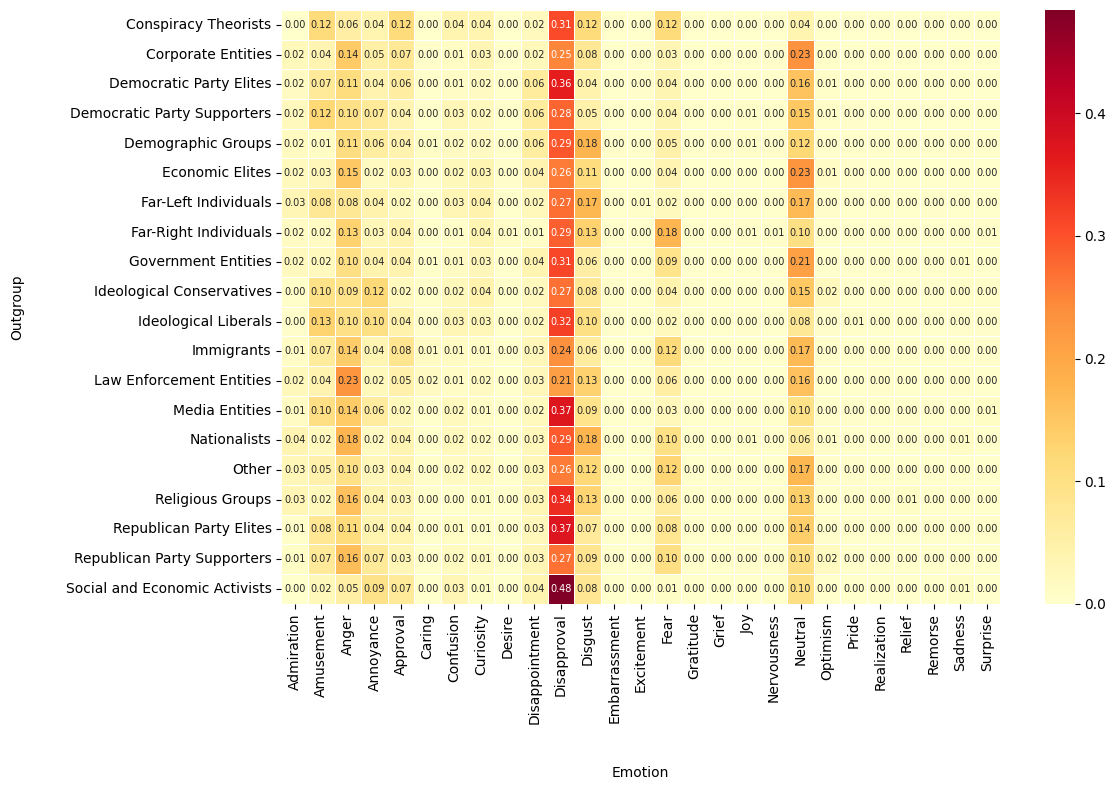

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("reddit_data_llm_analysis_nooutgroup.csv")

# Replace with your actual column names if different
emotion_col = 'emotion'
outgroup_col = 'outgroup_label'

# Create a pivot table: counts of emotions per outgroup
heatmap_data = df.pivot_table(index=outgroup_col,
                               columns=emotion_col,
                               aggfunc='size',
                               fill_value=0)

# Optional: Normalize rows to show % of emotion per outgroup
heatmap_data_normalized = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_normalized, cmap="YlOrRd", annot=True, fmt=".2f", linewidths=0.5, annot_kws={"size": 7})
plt.xlabel("Emotion", labelpad=30, loc='center')
plt.ylabel("Outgroup", labelpad=30, loc='center')
plt.tight_layout()
plt.savefig("heatmapv1.png", dpi=300, bbox_inches='tight')
plt.show()


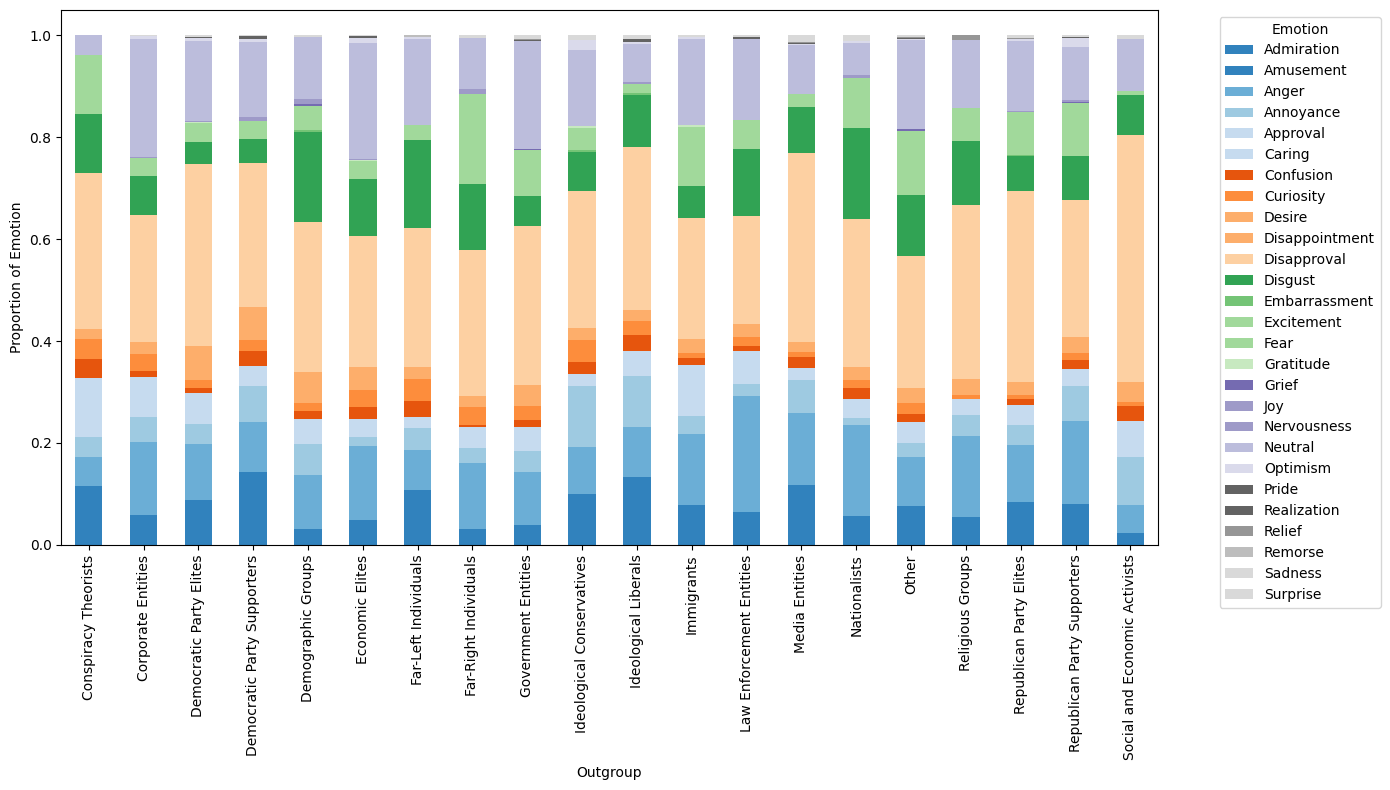

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your cleaned data
df = pd.read_csv("reddit_data_llm_analysis_nooutgroup.csv")

# Count the number of posts per (outgroup, emotion)
grouped = df.groupby(['outgroup_label', 'emotion']).size().unstack(fill_value=0)

# Normalize to get proportions per outgroup (i.e., each row sums to 1)
grouped_normalized = grouped.div(grouped.sum(axis=1), axis=0)

# Plot
ax = grouped_normalized.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20c')

# Customize appearance
plt.xlabel("Outgroup")
plt.ylabel("Proportion of Emotion")
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


plt.show()


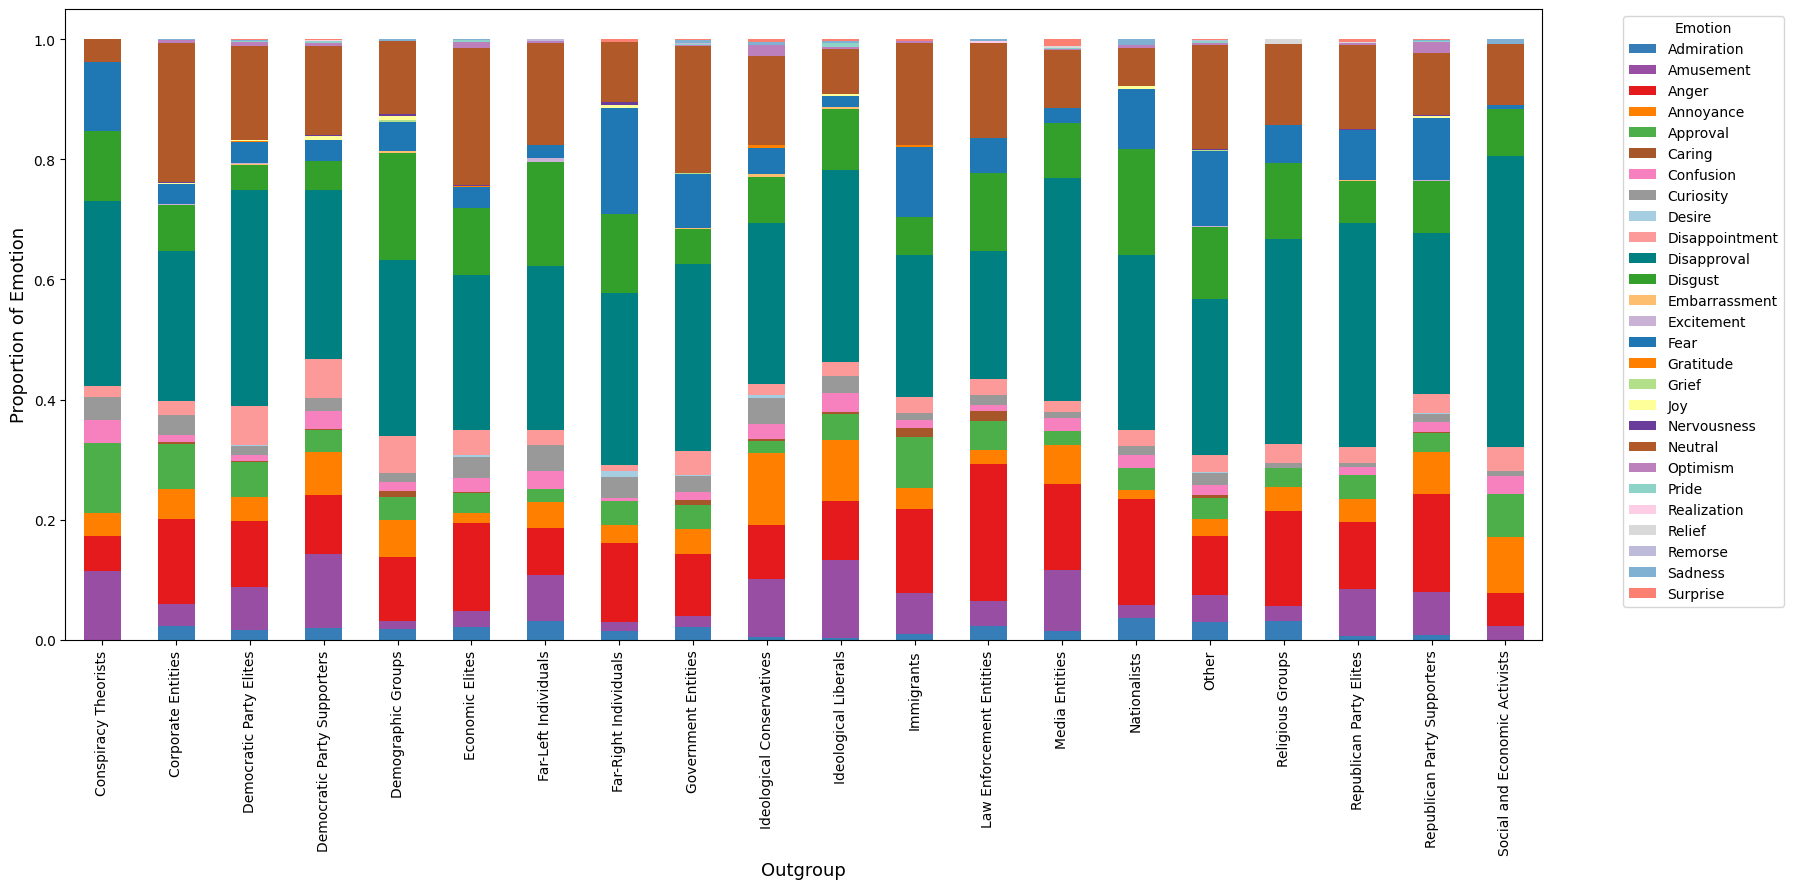

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load and Prepare Data ===
# Replace with your actual CSV path if different
df = pd.read_csv("reddit_data_llm_analysis_nooutgroup.csv")

# Group by outgroup and emotion
grouped = df.groupby(["outgroup_label", "emotion"]).size().unstack(fill_value=0)

# Normalize to get emotion proportions per outgroup
grouped_normalized = grouped.div(grouped.sum(axis=1), axis=0)

# Optional: sort emotions alphabetically or use a custom order
emotion_order = sorted(grouped_normalized.columns.tolist())
grouped_normalized = grouped_normalized[emotion_order]

# === Custom Color Dictionary for Emotions (based on Plutchik & readability) ===
emotion_colors = {
    'Admiration': '#377eb8',
    'Amusement': '#984ea3',
    'Anger': '#e41a1c',
    'Annoyance': '#ff7f00',
    'Approval': '#4daf4a',
    'Caring': '#a65628',
    'Confusion': '#f781bf',
    'Curiosity': '#999999',
    'Desire': '#a6cee3',
    'Disappointment': '#fb9a99',
    'Disapproval': '#008080',
    'Disgust': '#33a02c',
    'Embarrassment': '#fdbf6f',
    'Excitement': '#cab2d6',
    'Fear': '#1f78b4',
    'Gratitude': '#ff7f00',
    'Grief': '#b2df8a',
    'Joy': '#ffff99',
    'Nervousness': '#6a3d9a',
    'Neutral': '#b15928',
    'Optimism': '#bc80bd',
    'Pride': '#8dd3c7',
    'Realization': '#fccde5',
    'Relief': '#d9d9d9',
    'Remorse': '#bebada',
    'Sadness': '#80b1d3',
    'Surprise': '#fb8072'
}

# Assign colors to each emotion
bar_colors = [emotion_colors.get(emotion, '#808080') for emotion in emotion_order]  # fallback: gray

# === Plotting ===
ax = grouped_normalized.plot(
    kind='bar',
    stacked=True,
    figsize=(18, 9),
    color=bar_colors
)

# === Aesthetics ===
plt.xlabel("Outgroup", fontsize=13)
plt.ylabel("Proportion of Emotion", fontsize=13)
plt.xticks(rotation=90)
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
plt.tight_layout()
plt.savefig("stackedbar.png", dpi=300, bbox_inches='tight')
plt.show()